# 3-1. 분석용 데이터 준비

### 기본 라이브러리 Import

In [ ]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
# 파이토치 라이브러리 import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# PyTorch

In [ ]:
# tensor 생성
# numpy에서의 numpy.array, pandas에서의 pandas.Series 등과 같이 pytorch에서 사용하는 데이터구조
# numpy, pandas와 같이 torch.tensor만의 전용 attribute와 method가 존재한다.
x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
print("type:{}".format(type(x)))
print("data type:{}".format(x.dtype))
print("shape:{}".format(x.shape))
print("2행 3열선택:{}".format(x[1,2].item()))
print("배열 shape 변경:{}".format(x.view(6,-1))) #남은 하나의 dimension을 -1로 지정하면 알아서 계산

type:<class 'torch.Tensor'>
data type:torch.int64
shape:torch.Size([3, 4])
2행 3열선택:7
배열 shape 변경:tensor([[ 1,  2],
        [ 3,  4],
        [ 5,  6],
        [ 7,  8],
        [ 9, 10],
        [11, 12]])


In [ ]:
# GPU나 다른 연산 가속을 위한 하드웨어에서 실행 가능
device = ('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device) #작업내의 모든 tensor는 같은 장치에 있어야 한다.
x

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]], device='cuda:0')

In [ ]:
x = x.to('cpu')
x

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

In [ ]:
# 다른 라이브러리에는 없는 torch.tensor만의 특징 - 2
# 그래프 계산을 추적 (pytorch.autograd)
x = torch.tensor([3], dtype=torch.float, requires_grad=True)
f = x.pow(3)+ 1 #x^2 + 1 = 10
print("forward 결과:{}".format(f))
print("x.grad(forward):{}".format(x.grad))
f.backward() #2x #backward()함수는 f에 대해 미분을 수행하여 그 결과를 x.grad attribute에 저장
print("x.grad(backward):{}".format(x.grad))

forward 결과:tensor([28.], grad_fn=<AddBackward0>)
x.grad(forward):None
x.grad(backward):tensor([27.])


###구성모듈

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 간단한 딥러닝 모델 구성
import torch.nn.functional as F
class NeuralNetwork(nn.Module):
  # 네트워크 구성
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

  #순전파, init()함수에서 정의한 동작을 차례로 실행
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
# NeuralNetwork의 인스턴스(instance)를 생성하고 이를 device로 이동한 뒤, 구조(structure)를 출력
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Activation Function (Softmax)

In [ ]:
# sofmax 사례 1
x_input = torch.tensor([[0.7, 0.9]])
y_output = F.softmax(x_input, dim=1)
print(x_input)
print(y_output) # print(x_input.exp()/x_input.exp().sum())
# softmax 사례 2
x_input = torch.tensor([[-0.5, 0.1]])
y_output = F.softmax(x_input, dim=1)
print(x_input)
print(y_output)

tensor([[0.7000, 0.9000]])
tensor([[0.4502, 0.5498]])
tensor([[0.4502, 0.5498]])
tensor([[-0.5000,  0.1000]])
tensor([[0.3543, 0.6457]])


### Loss Function (Cross Entropy)

In [ ]:
x_input = torch.tensor([[2, 0.1]])
y_output = F.softmax(x_input, dim=1)
print(x_input)
print(y_output)
print(y_output.exp().sum().log() - y_output)

tensor([[2.0000, 0.1000]])
tensor([[0.8699, 0.1301]])
tensor([[0.3902, 1.1299]])


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
#샘플 2개에 대해서, target이 [1, 0] 이었을 때와 [0, 1]이었을 때 (두가지 경우에 대해)
test_pred_y = torch.tensor([[2.0, 0.1], # => 0
[0.1, 1.5]]) # => 1
#print(test_pred_y.exp()/test_pred_y.exp().sum())
test_true_y1 = torch.tensor([1,0]).long()
test_true_y2 = torch.tensor([0,1]).long()

print(loss_fn(test_pred_y, test_true_y1))
print(loss_fn(test_pred_y, test_true_y2)) #동일한 Class 예측을 한 y2와의 loss가 작음

#print(test_pred_y.exp().sum().log())
output = torch.tensor([2.0, 0.1])
target = [1]
loss1 = np.log(sum(np.exp(output))) - output[target[0]]
output = torch.tensor([0.1, 1.5])
target = [0]
loss2 = np.log(sum(np.exp(output))) - output[target[0]]

print((loss1 + loss2)/2)

tensor(1.8299)
tensor(0.1799)
tensor(1.8299)


# 3-4. 모델링

### 데이터 로드

In [ ]:
# 구글 드라이브 mount
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 데이터 파일 위치
colab_path = "gdrive/My Drive/Colab Notebooks/KISIA/네트워크/part3/"

#전처리된 데이터 로드
df_orig = pd.read_csv(colab_path + 'data_processed/kdd_processed.csv')

In [ ]:
#딥러닝 연산을 위해 output값에 대해 형변환을 수행한다.
df_orig['label_cate'] = df_orig['label_cate'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
df_orig['label_cate'].value_counts(dropna=False)

label_cate
1    391458
0     97278
2      4107
3      1126
4        52
Name: count, dtype: int64

In [ ]:
# Feature(X), Label(y) 분리
target_col = 'label_cate'
cols_to_exclude = ['label', 'label_cate', 'label_binary']
cols_to_train = df_orig.columns.drop(cols_to_exclude)
y = df_orig[target_col]
X = df_orig[cols_to_train]
X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.067792,-0.002879,0.138664,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
1,-0.067792,-0.002820,-0.011578,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
2,-0.067792,-0.002824,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
3,-0.067792,-0.002840,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
4,-0.067792,-0.002842,0.035214,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,-0.067792,-0.002748,0.030644,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
494017,-0.067792,-0.002776,0.042902,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
494018,-0.067792,-0.002856,0.010032,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0
494019,-0.067792,-0.002767,0.010032,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.39698,-0.005679,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# 테스트용 데이터 분할
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42 )
train_X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
228201,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
483696,-0.067792,-0.002811,0.077072,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396980,-0.005679,...,0,0,0,0,0,0,0,0,1,0
234556,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
127627,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,1,0,0,0,0,0
463534,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
365838,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,1,0,0,0,0,0
131932,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
146867,12.847863,-0.002913,-0.023109,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# DataSet 클래스 구성
# Dataframe으로 입력받아서 torch타입으로 데이터 변형.
# Map스타일의 커스텀 DataSet은 기본적으로 getitem()과 len() 함수를 overide 합니다.

class kddDataset(Dataset):
    def __init__(self, X, y):
        self.X_values = X.values
        self.y_values = y.values

    def __len__(self):
        return self.X_values.shape[0]

    def __getitem__(self, idx):
        item = dict()
        item["features"] = torch.tensor(self.X_values[idx]).float()
        item["target"] = torch.tensor(self.y_values[idx]).long()  ##cross entropy 계산을 위해 long type으로
        return item

In [ ]:
# 간단한 딥러닝 모델 구성
class kddNN(torch.nn.Module):
    # 네트워크 구성
    def __init__(self, input_size, h1_size, h2_size, output_size=2):
        super().__init__()  #파라미터 초기화
        self.fc1 = torch.nn.Linear(input_size, h1_size)  #fc: fully-connected 지칭하기 위한 일반적인 명명관습
        self.fc2 = torch.nn.Linear(h1_size, h2_size)    #히든레이어 추가 삽입시
        self.out = torch.nn.Linear(h2_size, output_size)

    #순전파, init()함수에서 정의한 동작을 차례로 실행
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x) #loss function으로 CrossEntropyLoss를 사용하고 있어 softmax()로 구성안함
        return x

In [ ]:
# 간단한 딥러닝 모델 구성
class kddNN2(torch.nn.Module):
    # 네트워크 구성
    def __init__(self, input_size, h1_size, h2_size, output_size=2):
        super().__init__()  #파라미터 초기화
        self.fc1 = torch.nn.Linear(input_size, h1_size)  #fc: fully-connected 지칭하기 위한 일반적인 명명관습
        self.dropout1 = torch.nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(h1_size, h2_size)    #히든레이어 추가 삽입시
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.out = torch.nn.Linear(h2_size, output_size)

    #순전파, init()함수에서 정의한 동작을 차례로 실행
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x) #loss function으로 CrossEntropyLoss를 사용하고 있어 softmax()로 구성안함
        return x

In [ ]:
def train(dataset, model, device, n_epochs, batch_size):
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_loss_history = []
    val_loss_history = []

    train_length = int(len(dataset)*0.7)
    val_length = len(dataset) - train_length
    train_set, val_set = random_split(dataset, [train_length, val_length])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    for e in range(int(n_epochs)):

        # 학습
        train_loss = 0
        model.train()  #모델을 학습 모드로 설정
        for batch in train_loader:
            optimizer.zero_grad()  #backpropagation 할때마다 zero out해주지 않으면 누적됨
            inputs = batch["features"].to(device)
            labels = batch["target"].to(device)
            preds = model(inputs) #foward 실행

            loss = loss_fn(preds, labels)
            loss.backward()       #back-propagation, gradient 계산
            optimizer.step()      #gradient에 근거하여 parameter 조정
            train_loss += loss.item()  #batch 전체 누적하여 1 epoch의 loss값 계산
        train_loss_history.append(train_loss/len(train_loader))

        # validation
        val_loss = 0
        num_correct = 0
        model.eval()  #모델을 평가 모드로 설정
        for batch in val_loader:
            inputs = batch["features"].to(device)
            labels = batch["target"].to(device)
            preds = model(inputs) #foward 계산
            _, predicted = torch.max(preds, dim=1)
            num_correct += (predicted == labels).float().sum()
            loss = loss_fn(preds, labels)
            val_loss += loss.item()  #batch 전체 누적하여 1 epoch의 loss값 계산
        val_loss_history.append(val_loss/len(val_loader))
        accuracy = num_correct/(len(val_set))
        if (e % 10) == 0:
            print("Epoch: {} Train loss: {} Validation loss: {} Accuracy: {}".format(e, train_loss/len(train_loader), val_loss/len(val_loader), accuracy))
    return train_loss_history, val_loss_history

In [ ]:
%%time
#학습 & 평가
EPOCHS = 100
BATCH_SIZE = 5000
DEVICE = ('cuda' if torch.cuda.is_available()  else 'cpu')

train_data = kddDataset(train_X, train_y)
input_size = len(cols_to_train)
h1_size = input_size*2
model = kddNN(input_size, h1_size, 32, 5).to(device=DEVICE)
train_loss_hist, val_loss_hist = train(train_data, model, DEVICE, EPOCHS, BATCH_SIZE)

Epoch: 0 Train loss: 1.420870652004164 Validation loss: 1.1928894292740595 Accuracy: 0.792481541633606
Epoch: 10 Train loss: 0.09710846050661437 Validation loss: 0.09554555586406163 Accuracy: 0.9839606285095215
Epoch: 20 Train loss: 0.06537337920495442 Validation loss: 0.06565129561793237 Accuracy: 0.9842883944511414
Epoch: 30 Train loss: 0.05260535276361874 Validation loss: 0.05339343863583747 Accuracy: 0.9875752925872803
Epoch: 40 Train loss: 0.04404133520260149 Validation loss: 0.045221185577767234 Accuracy: 0.99027419090271
Epoch: 50 Train loss: 0.03683610682432749 Validation loss: 0.03834348872658752 Accuracy: 0.9902260303497314
Epoch: 60 Train loss: 0.031227846344818875 Validation loss: 0.03284315126282828 Accuracy: 0.9914116263389587
Epoch: 70 Train loss: 0.026173336963568414 Validation loss: 0.027890281396962348 Accuracy: 0.9915562272071838
Epoch: 80 Train loss: 0.022321214747368073 Validation loss: 0.024211920265640532 Accuracy: 0.9946213960647583
Epoch: 90 Train loss: 0.01971

In [ ]:
torch.save(model.state_dict(),colab_path + 'data_processed/model.pth')

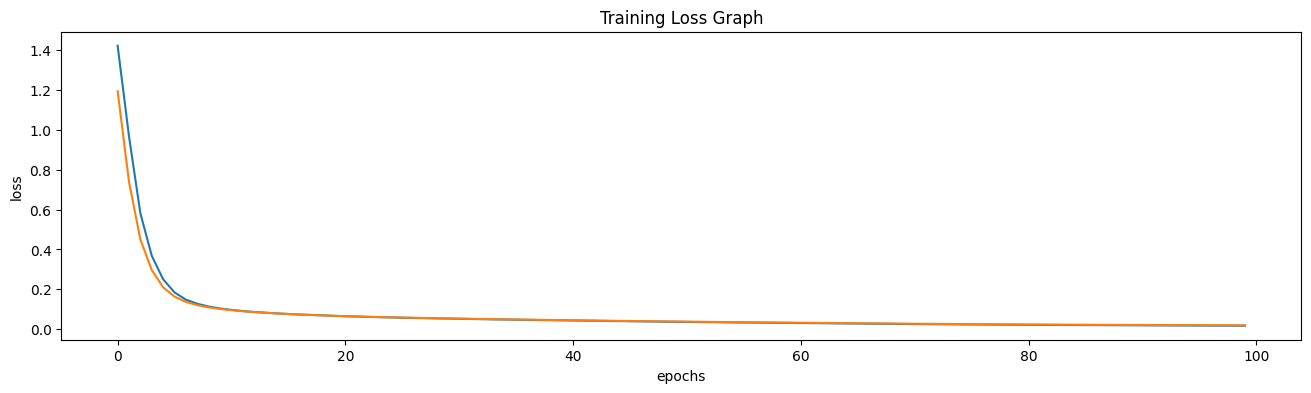

In [ ]:
# Loss 추이 확인 (적절한 Epoch 확인)
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.show()

In [ ]:
import torch
import torch.nn as nn

#학습 & 평가
EPOCHS = 100
BATCH_SIZE = 5000
DEVICE = ('cuda' if torch.cuda.is_available()  else 'cpu')
DEVICE = 'cpu'
train_data = kddDataset(train_X, train_y)
input_size = len(cols_to_train)
h1_size = input_size*2

# 모델 초기화
model = kddNN(input_size, h1_size, 32, 5).to(device=DEVICE)

# 저장된 모델 상태 로드
#model.load_state_dict(torch.load(colab_path + 'data_processed/model.pth'))

PATH = colab_path + 'data_processed/model.pth'
device = torch.device('cpu')
model.load_state_dict(torch.load(PATH, map_location=device))

# 모델을 평가 모드로 전환 (필요한 경우)
model.eval()

kddNN(
  (fc1): Linear(in_features=118, out_features=236, bias=True)
  (fc2): Linear(in_features=236, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=5, bias=True)
)

In [ ]:
def predict(dataset, model, device, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) #Predict 모드에서는 shuffle 안함
    pred_y_list = []
    num_correct = 0
    model.eval()  #모델을 평가 모드로 설정
    for batch in dataloader:
        inputs = batch["features"].to(device)
        labels = batch["target"].to(device)
        preds = model(inputs) #foward 학습
        _, predicted = torch.max(preds, dim=1)
        num_correct += (predicted == labels).float().sum()
        pred_y_list.append(predicted) #batch 마다 predict 결과를 누적
    accuracy = num_correct/(len(dataset))
    print("Accuracy: {}".format(accuracy))
    pred_y = torch.cat(pred_y_list)
    return pred_y

In [ ]:
# 테스트 데이터에 대해 predict 수행
test_data = kddDataset(test_X, test_y)
pred_y = predict(test_data, model, DEVICE, BATCH_SIZE)

Accuracy: 0.9960190653800964


In [ ]:
# 모델 성능 - confusion matrix
conf_mat = confusion_matrix(y_true=test_y, y_pred=list(pred_y))
conf_mat

array([[ 29090,     24,     42,     36,      0],
       [    37, 117354,      3,      0,      0],
       [   167,     12,   1076,      0,      0],
       [   224,      6,     22,     97,      0],
       [    11,      1,      5,      0,      0]])

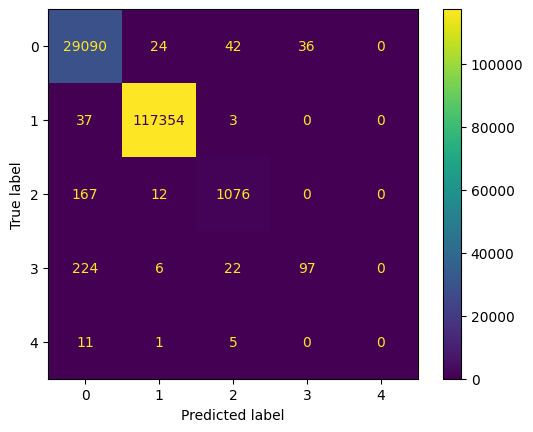

In [ ]:
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

In [ ]:
%%time
#학습 & 평가
EPOCHS = 100
BATCH_SIZE = 5000
DEVICE = ('cuda' if torch.cuda.is_available()  else 'cpu')

train_data = kddDataset(train_X, train_y)
input_size = len(cols_to_train)
h1_size = input_size*2
model = kddNN2(input_size, h1_size, 32, 5).to(device=DEVICE)
train_loss_hist, val_loss_hist = train(train_data, model, DEVICE, EPOCHS, BATCH_SIZE)

Epoch: 0 Train loss: 1.542535969189235 Validation loss: 1.3549489577611287 Accuracy: 0.8133018016815186
Epoch: 10 Train loss: 0.1782665404738212 Validation loss: 0.11551137552374885 Accuracy: 0.9823701977729797
Epoch: 20 Train loss: 0.10259838447887071 Validation loss: 0.07019232869857833 Accuracy: 0.9837582111358643
Epoch: 30 Train loss: 0.08477157582433856 Validation loss: 0.06022724154449645 Accuracy: 0.983912467956543
Epoch: 40 Train loss: 0.07382005141401778 Validation loss: 0.054578597169546855 Accuracy: 0.983941376209259
Epoch: 50 Train loss: 0.06693953275680542 Validation loss: 0.04990970698140916 Accuracy: 0.9842594861984253
Epoch: 60 Train loss: 0.06101123623701991 Validation loss: 0.04520376133067267 Accuracy: 0.9877102375030518
Epoch: 70 Train loss: 0.05568698778444407 Validation loss: 0.04047793611174538 Accuracy: 0.9882692694664001
Epoch: 80 Train loss: 0.05089174568349002 Validation loss: 0.03572949589717956 Accuracy: 0.9904766082763672
Epoch: 90 Train loss: 0.0461204445

In [ ]:
# 테스트 데이터에 대해 predict 수행
test_data = kddDataset(test_X, test_y)
pred_y = predict(test_data, model, DEVICE, BATCH_SIZE)

Accuracy: 0.9918222427368164


#Keras를 이용하자

In [ ]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

#Keras Import
import tensorflow as tf
from tensorflow.keras import layers
from datetime import timedelta, datetime

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 구글 드라이브 mount
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 데이터 파일 위치
colab_path = "gdrive/My Drive/Colab Notebooks/KISIA/네트워크/part3/"

#전처리된 데이터 로드
df_orig = pd.read_csv(colab_path + 'data_processed/kdd_processed.csv')

In [ ]:
#target에 one hot encoding 변환
dummies = pd.get_dummies(df_orig['label_cate']) # Classification
#df_orig['label_cate'] = df_orig['label_cate'].map({'normal':0, 'dos':1, 'probe':2, 'r2l':3, 'u2r':4})
#df_orig['label_cate'].value_counts(dropna=False)

In [ ]:
# Feature(X), Label(y) 분리
cols_to_exclude = ['label', 'label_cate', 'label_binary']
cols_to_train = df_orig.columns.drop(cols_to_exclude)

X = df_orig[cols_to_train]
X
outcomes = dummies.columns
num_classes = len(outcomes)
Y = dummies.values
Y

array([[False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       ...,
       [False,  True, False, False, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False]])

In [ ]:
# 테스트용 데이터 분할
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=42 )
train_X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
228201,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
483696,-0.067792,-0.002811,0.077072,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396980,-0.005679,...,0,0,0,0,0,0,0,0,1,0
234556,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
127627,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,1,0,0,0,0,0
463534,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
365838,-0.067792,-0.003062,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,1,0,0,0,0,0
131932,-0.067792,-0.002017,-0.026287,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0
146867,12.847863,-0.002913,-0.023109,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,-0.417192,-0.005679,...,0,0,0,0,0,0,0,0,1,0


### ANN 구성

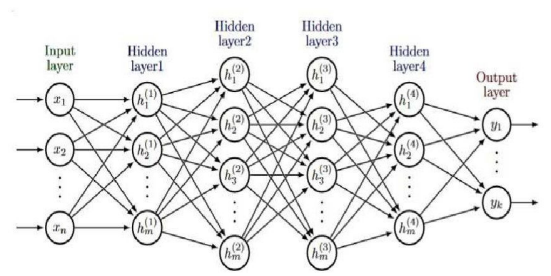

In [ ]:
#model1
initializer = tf.keras.initializers.GlorotUniform(seed=42)
constraints = None

model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, input_dim=train_X.shape[1], kernel_initializer=initializer, kernel_constraint=constraints, \
                        activation='relu',name='dense_1a'),
  tf.keras.layers.Dense(128, input_dim=train_X.shape[1], kernel_initializer=initializer, kernel_constraint=constraints,\
                        activation='relu',name='dense_1b'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, input_dim=train_X.shape[1], kernel_initializer=initializer, kernel_constraint=constraints,\
                        activation='relu',name='dense_1c'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, input_dim=train_X.shape[1], kernel_initializer=initializer, kernel_constraint=constraints,\
                        activation='relu',name='dense_1d'),
  tf.keras.layers.Dense(train_y.shape[1],activation='softmax')
  ])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1a (Dense)            (None, 128)               15232     
                                                                 
 dense_1b (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1c (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1d (Dense)            (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                

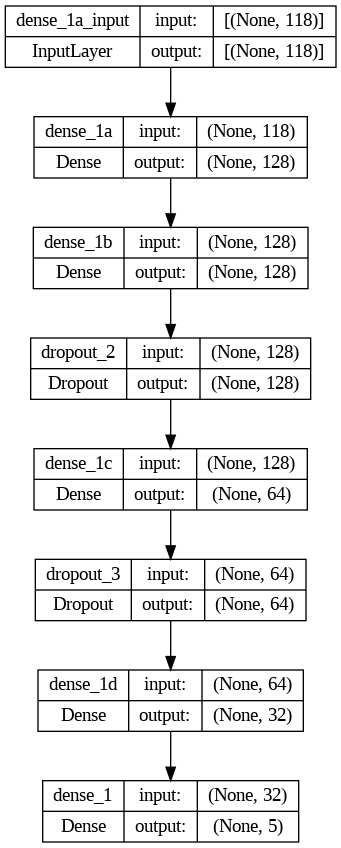

In [ ]:
# 추가 코드 - 모델의 아키텍처를 표시하는 또 다른 방법
model_1.summary()
tf.keras.utils.plot_model(model_1, "model_1.png", show_shapes=True)

In [ ]:
#model 1
model_1.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_1 = colab_path + "model_1"
print(log_dir_1)
monitor_1 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5,\
                patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_1, histogram_freq=1)
            ]
history_1  = model_1.fit(train_X,train_y,validation_data=(test_X,test_y), \
                         verbose=2, batch_size=1024, epochs=20)
model_1.save(colab_path + 'model1.h5')

gdrive/My Drive/Colab Notebooks/KISIA/네트워크/part3/model_1
Epoch 1/20
338/338 - 9s - loss: 0.0708 - accuracy: 0.9872 - val_loss: 0.0067 - val_accuracy: 0.9985 - 9s/epoch - 27ms/step
Epoch 2/20
338/338 - 5s - loss: 0.0073 - accuracy: 0.9985 - val_loss: 0.0047 - val_accuracy: 0.9989 - 5s/epoch - 16ms/step
Epoch 3/20
338/338 - 7s - loss: 0.0051 - accuracy: 0.9988 - val_loss: 0.0039 - val_accuracy: 0.9991 - 7s/epoch - 20ms/step
Epoch 4/20
338/338 - 4s - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0039 - val_accuracy: 0.9991 - 4s/epoch - 13ms/step
Epoch 5/20
338/338 - 8s - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.0031 - val_accuracy: 0.9993 - 8s/epoch - 24ms/step
Epoch 6/20
338/338 - 5s - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9992 - 5s/epoch - 15ms/step
Epoch 7/20
338/338 - 4s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9993 - 4s/epoch - 12ms/step
Epoch 8/20
338/338 - 4s - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0032 - val

In [5]:
#model_1.save(colab_path + 'model1.h5')
#model_1.load_model(colab_path + 'model1.h5')
model_1 = load_model(colab_path + 'model1.h5')

NameError: name 'load_model' is not defined

In [3]:
pred_Y = model_1.predict(test_X)

#test_loss, test_acc = model_1.evaluate(test_X,  test_y, verbose=2)

NameError: name 'model_1' is not defined

In [ ]:
y1 = tf.argmax(test_y, axis=1)
y1

<tf.Tensor: shape=(148207,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import *

yhat_val = tf.argmax(pred_Y, axis=1)
acc = accuracy_score(y1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)
print(classification_report(y1, yhat_val))

Stacked Test Accuracy: 0.9994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117394
           1       1.00      1.00      1.00     29192
           2       0.99      0.99      0.99      1255
           3       0.96      0.90      0.93       349
           4       0.88      0.41      0.56        17

    accuracy                           1.00    148207
   macro avg       0.96      0.86      0.90    148207
weighted avg       1.00      1.00      1.00    148207



In [ ]:
# 모델 성능 - confusion matrix
conf_mat = confusion_matrix(y_true=y1, y_pred=list(yhat_val))
conf_mat

array([[117390,      4,      0,      0,      0],
       [     1,  29164,     16,     11,      0],
       [     0,     10,   1245,      0,      0],
       [     0,     35,      0,    313,      1],
       [     0,      8,      0,      2,      7]])

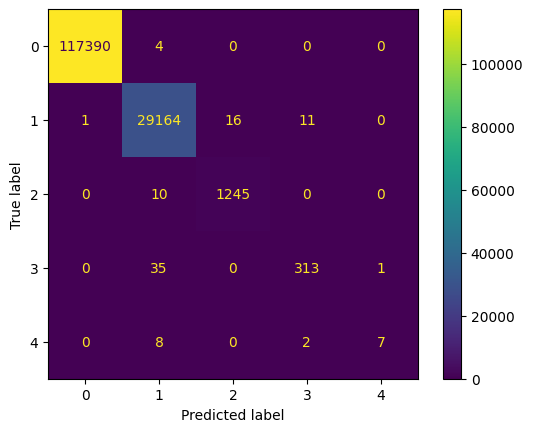

In [ ]:
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()